# Hough Transform



## 1. Hough Transform

### GPU ver 확인

In [1]:
# gpu ver 확인
!nvidia-smi

Wed Oct  9 09:55:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 필요 라이브러리 설치

In [2]:

!pip install opencv-python-headless
!pip install transformers
!pip install -qq opencv-contrib-python diffusers transformers git+https://github.com/huggingface/accelerate.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.8 MB/s eta 0:00:00


In [ ]:

# print(cv2.cuda.getCudaEnabledDeviceCount())

In [3]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
from diffusers import UniPCMultistepScheduler
import cv2
from PIL import Image
import numpy as np
from transformers.utils import move_cache
from google.colab.patches import cv2_imshow

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
move_cache(0)

0it [00:00, ?it/s]

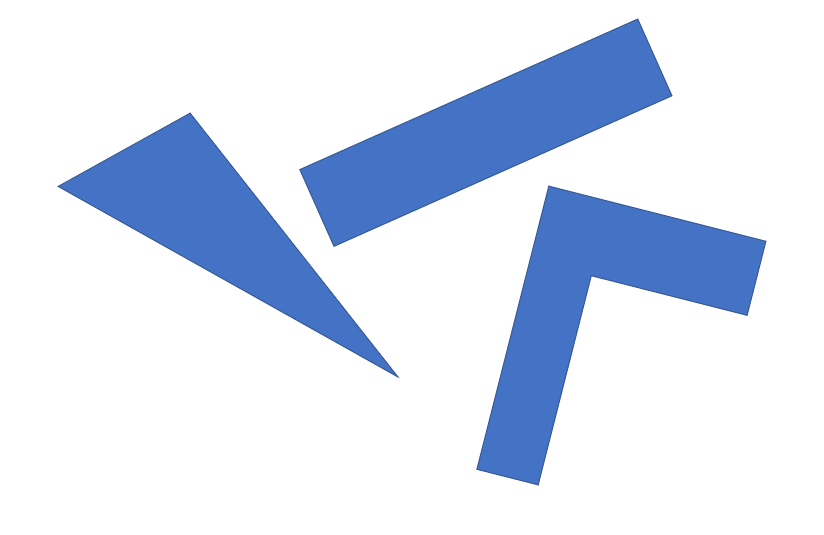

In [5]:
# 사용할 이미지 로드 : sample.png
samimg = load_image('/content/sample.png')
samimg

### Edge 추출
- canny등 전처리를 이요해 edge를 추출한다. 그 이후 Hough Transform을 적용한다

In [6]:
print(type(samimg))

<class 'PIL.Image.Image'>


In [7]:
# image의 형식이 PIL이므로 array 형식으로 변환해준다.
img = np.array(samimg)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
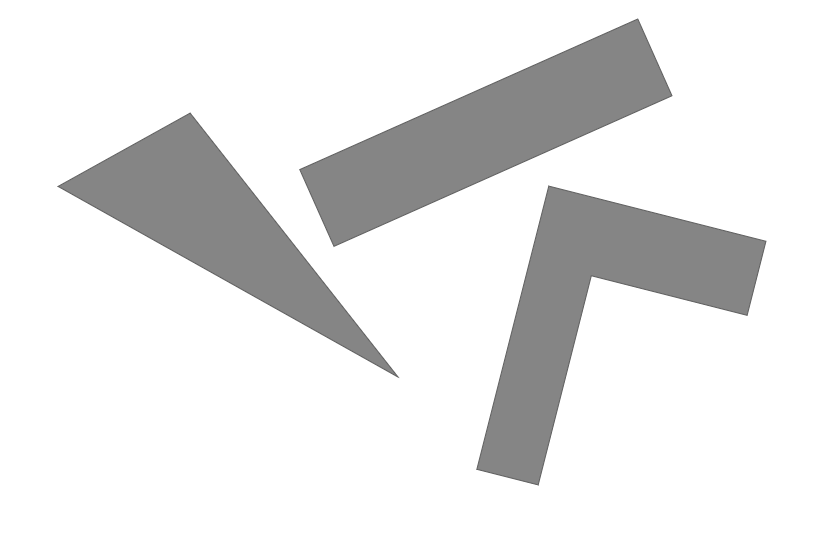

In [8]:
# img를 grayscale 시켜준다.
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
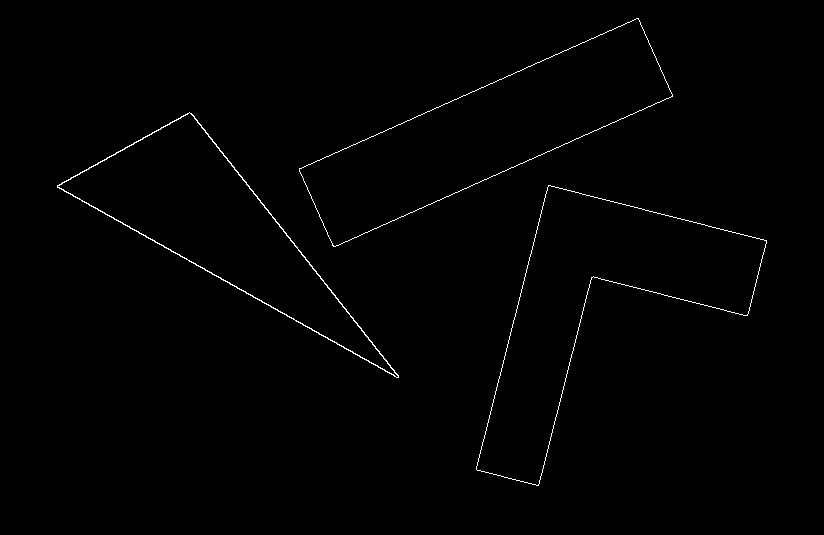

In [9]:
img_canny = cv2.Canny(img_gray,50, 150, apertureSize=3)
img_canny

In [ ]:
cv2.HoughLines()

In [ ]:
# hough_transform_int :

def hough_transform_int(image, theta_res=1, rho_res=1):
    height, width = image.shape
    diag_len = int(np.round(np.sqrt(height**2 + width**2)))
    rhos = np.linspace(-diag_len, diag_len, int(2*diag_len/rho_res))
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    accum = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(image)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            rho = int(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accum[rho, t_idx] += 1

    return accum, thetas, rhos

In [ ]:
def hough_transform(image, theta_res=1, rho_res=1):
    height, width = image.shape
    # 정확도 문제로 int 변환 안하고 그대로 float 형태로 둠
    diag_len = np.sqrt(height**2 + width**2)

    # rhos 계산 시 정수로 변환
    num_rhos = int(2 * diag_len / rho_res)
    rhos = np.linspace(-diag_len, diag_len, num_rhos)

    thetas = np.deg2rad(np.arange(-90, 90, theta_res))

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    accumulator = np.zeros((num_rhos, len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(image)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            # rho 계산 시 정수로 변환하고, diag_len을 더하는 대신 rhos의 중간 인덱스를 사용
            rho = int((x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            rho_idx = int(rho / rho_res)
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, t_idx] += 1

    return accumulator, thetas, rhos

In [ ]:
# claude 개선 코드 srn, stn 고려

def hough_transform(image, rho, theta, threshold, srn=0, stn=0):
    height, width = image.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))

    if srn == 0 and stn == 0:
        # 표준 Hough 변환
        num_rhos = int(2 * diag_len / rho)
        rhos = np.linspace(-diag_len, diag_len, num_rhos)
        thetas = np.arange(-np.pi/2, np.pi/2, theta)
    else:
        # 멀티스케일 Hough 변환
        num_rhos = int(2 * diag_len / (rho * srn))
        num_thetas = int(np.pi / (theta * stn))
        rhos = np.linspace(-diag_len, diag_len, num_rhos)
        thetas = np.linspace(-np.pi/2, np.pi/2, num_thetas)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    accum = np.zeros((len(rhos), len(thetas)), dtype=np.uint32)
    y_idxs, x_idxs = np.nonzero(image)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int((x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            if 0 <= rho < len(rhos):
                accum[rho, t_idx] += 1

    lines = []
    for r in range(len(rhos)):
        for t in range(len(thetas)):
            if accum[r, t] > threshold:
                lines.append((rhos[r] - diag_len, thetas[t]))

    return np.array(lines)

# 사용 예
image = np.zeros((100, 100), dtype=np.uint8)
image[25:75, 50] = 255  # 수직선 그리기

rho = 1
theta = np.pi / 180
threshold = 50

# 표준 Hough 변환
lines_standard = hough_transform(image, rho, theta, threshold)
print("Standard Hough Transform:", lines_standard)

# 멀티스케일 Hough 변환
lines_multiscale = hough_transform(image, rho, theta, threshold, srn=2, stn=2)
print("Multiscale Hough Transform:", lines_multiscale)

In [ ]:
accum, thetas, rhos = hough_transform(img_canny)

In [ ]:
accum[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=uint64)

In [ ]:
def GetLines(image, accumulator, thetas, rhos, maxval = 0.6):
  new_image = np.ones(image.shape, dtype=np.uint8) * 255
  threshold = np.max(accumulator) * maxval
  y_idxs, x_idxs = np.where(accumulator > threshold)
  for y_idx, x_idx in zip(y_idxs, x_idxs):
    rho = rhos[y_idx]
    theta = thetas[x_idx]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(new_image, (x1, y1), (x2, y2), (0, 0, 255), 2) # line color = RED
  return new_image

In [ ]:
def GetLinesOrigin(image, accumulator, thetas, rhos, maxval = 0.6):
  #new_image = np.ones(image.shape, dtype=np.uint8) * 255
  threshold = np.max(accumulator) * maxval
  y_idxs, x_idxs = np.where(accumulator > threshold)
  for y_idx, x_idx in zip(y_idxs, x_idxs):
    rho = rhos[y_idx]
    theta = thetas[x_idx]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2) # line color = RED
  return image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
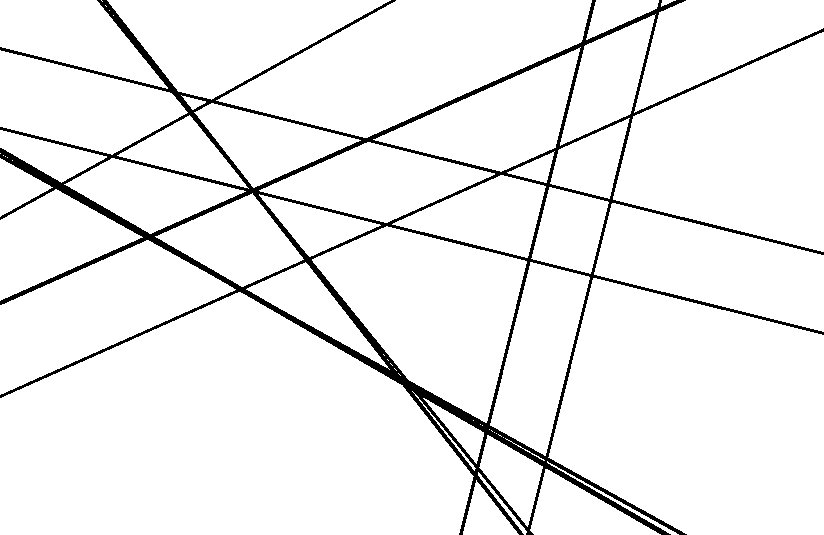

In [ ]:
temp_img = img_canny.copy()
GetLines(temp_img, accumulator, thetas, rhos, 0.4)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
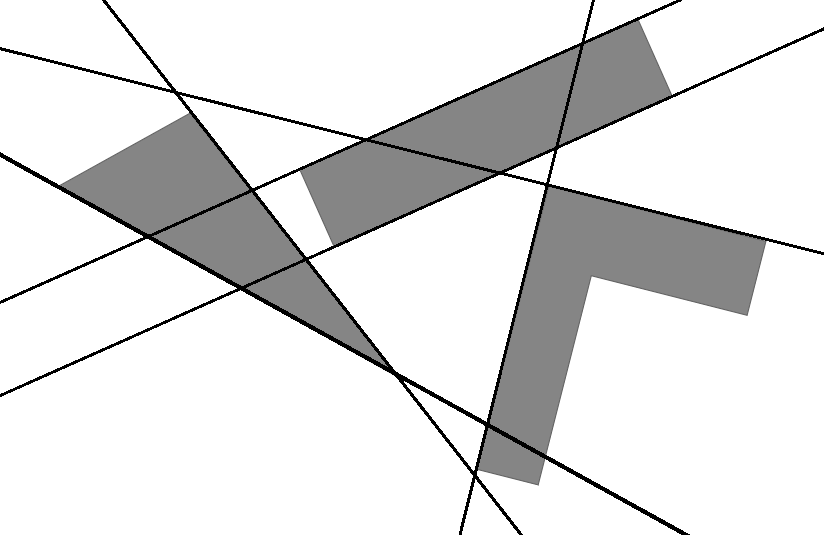

In [ ]:
temp_img = img_.copy()
GetLinesOrigin(temp_img, accumulator, thetas, rhos, 0.4)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
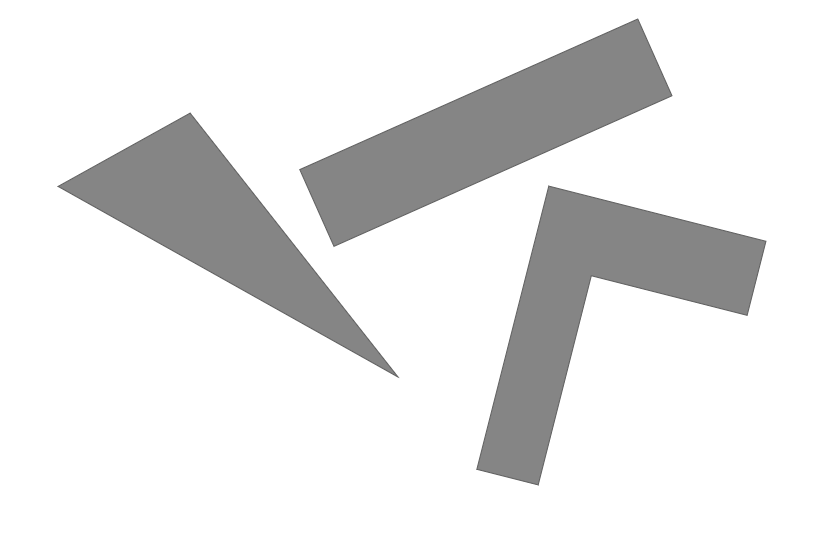

In [ ]:
img_

In [ ]:
temp_img = img_.copy()

In [ ]:
new_img =  np.ones(temp_img.shape, dtype=np.uint8) * 255
edges = cv2.Canny(temp_img, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)
lines[0]

array([[361.       ,   1.1519173]], dtype=float32)

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

# 결과 이미지에 선 그리기
result = temp_img.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
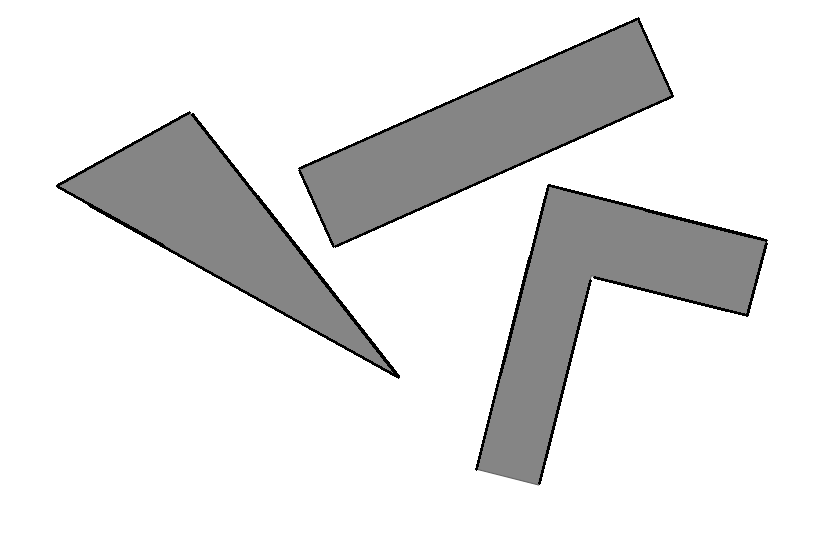

In [ ]:
result

In [ ]:
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

# 결과 이미지에 선 그리기
result = temp_img.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)